# Ants Bees VGG16 による解析

# Fitting 

# TypeBによるTrainingクラスの作成

In [1]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
'''
3. 前処理前後の画像を確認する
'''
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import torch
import torch.utils.data as data
from pathlib import Path


In [3]:
torch.cuda.synchronize()
print(torch.cuda.memory_allocated())

0


In [4]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data'
root_dir= '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data'

In [5]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/AntsBees')

###Deviceの設定

In [6]:
# 使用可能なデバイス(CPUまたはGPU）を取得する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#(1) DataSet の作成

### train_list, val_list の作成

In [7]:
import glob
import pprint

def make_datapath_list(phase='train'):
    '''
    データのファイルパスを格納したリストを作成する。

    Parameters:
      phase(str): 'train'または'val'

    Returns:
      path_list(list): 画像データのパスを格納したリスト
    '''
    # 画像ファイルのルートディレクトリ
    # 画像ファイルパスのフォーマットを作成
    # rootpath +
    #   train/ants/*.jpg
    #   train/bees/*.jpg
    #   val/ants/*.jpg
    #   val/bees/*.jpg
    tt= phase +'/**/*.jpg'
    target_path = os.path.join(root_dir,tt)
    # ファイルパスを格納するリスト
    path_list = []  # ここに格納する

    # glob()でファイルパスを取得してリストに追加
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

# ファイルパスのリストを生成
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

print(train_list)

# 訓練データのファイルパスの前後5要素ずつ出力
print('train')
pprint.pprint(train_list[:5])
pprint.pprint(train_list[-6:-1])
# 検証データのファイルパスの前後5要素ずつ出力
print('val')
pprint.pprint(val_list[:5])
pprint.pprint(val_list[-6:-1])

['/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/0013035.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg', '/cont

In [8]:
p=Path(train_list[5])
print(p.parts[-2])

p2=Path(val_list[-4])
print(p2.parts[-2])

ants
bees


#（２）DataSetの作成

In [9]:
from dsets.dsets import MakeDataset
from util.ImageTransform import ImageTransform

In [10]:
'''
6. データローダーの生成
'''
import torch

# ミニバッチのサイズを指定
batch_size = 10
SIZE = 224
# 標準化する際の各RGBの平均値
MEAN = (0.485, 0.456, 0.406) # ImageNetデータセットの平均値を使用
# 標準化する際の各RGBの標準偏差
STD = (0.229, 0.224, 0.225)  # ImageNetデータセットの標準偏差を使用


# 画像のサイズ、平均値、標準偏差の定数値
size, mean, std = SIZE, MEAN, STD

# MakeDatasetで前処理後の訓練データと正解ラベルを取得
train_dataset = MakeDataset(
    file_list=train_list, # 訓練データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='train')
# MakeDatasetで前処理後の検証データと正解ラベルを取得
val_dataset = MakeDataset(
    file_list=val_list, # 検証データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='val')


In [11]:
print(len(train_list))
print(len(val_list))

243
153


#(2) DataLoader の作成

In [12]:
'''
6. データローダーの生成
'''
from torch.utils.data import DataLoader

# 訓練用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 検証用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



#(4) モデルの作成

In [13]:
'''
7. 学習済みのVGG16モデルをロード
'''
from torchvision import models
import torch.nn as nn

# ImageNetで事前トレーニングされたVGG16モデルを取得
model = models.vgg16(pretrained=True)

# VGG16の出力層のユニット数を2にする
model.classifier[6] = nn.Linear(
    in_features=4096, # 入力サイズはデフォルトの4096
    out_features=2)   # 出力はデフォルトの1000から2に変更


'''
8. VGG16で学習可能にする層を設定
'''
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 出力層の重みとバイアスを更新可として登録
update_param_names = ['classifier.6.weight', 'classifier.6.bias']

# 出力層以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True # 勾配計算を行う
        params_to_update.append(param) # パラメーター値を更新
        print(name) # 更新するパラメーター名を出力
    else:
        param.requires_grad = False # 出力層以外は勾配計算なし    


model = model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

classifier.6.weight
classifier.6.bias
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_s

# For Loop with DataLoaderの研究

In [14]:
import os
print(os.getcwd())

/content/gdrive/My Drive/Colab Notebooks/AntsBees


In [15]:
import pickle
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

import torch.optim as optim

METRICS_LABEL_NDX=0
METRICS_PRED_NDX=1
METRICS_LOSS_NDX=2
METRICS_SIZE = 3


# 損失関数
criterion = nn.CrossEntropyLoss()

# オプティマイザー
optimizer = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.99)

metrics_dict = {'epoch_ndx':[],'phase':[],'loss/all':[],'loss/neg':[], 'loss/pos':[],'correct/all':[],'correct/neg':[],'correct/pos':[],'pr/precision':[],'pr/recall':[],'pr/f1_score':[]}

class training:
  def __init__(self):
    self.model=model 
    self.optimizer=optimizer
    self.num_epochs=10
    self.batch_size=10
    self.use_cuda = True
    #self.train_dl = train_dl
    #self.val_dl = val_dl
    self.device = torch.device("cuda" if self.use_cuda else "cpu")
    #self.augmentation_dict = opt.augmentation_dict
    self.save_dir = 'network'
    self.log_dir = 'logmetrics'

  def main(self):
    for epoch_ndx in range(self.num_epochs):
      trnMetrics_t = self.doTraining(epoch_ndx, train_dl)
      self.logMetrics(epoch_ndx, 'trn', trnMetrics_t)
      print('doTraining_end')

      valMetrics_t = self.doValidation(epoch_ndx, val_dl)
      self.logMetrics(epoch_ndx, 'val', valMetrics_t)
      print('doValidation_end')

      if epoch_ndx % 2 == 0:
        print('saving the model at the end of epoch %d' % (epoch_ndx))
        self.save_network(model,epoch_ndx)
        print('saving the logMetrics at the end of epoch %d' % (epoch_ndx))
        self.save_file(metrics_dict,epoch_ndx)


  def save_network(self, network, epoch_ndx, cpu=False):
      save_filename = 'net_%s.pth' % (epoch_ndx)
      save_path = os.path.join(self.save_dir, save_filename)
      torch.save(network.cpu().state_dict(), save_path)
      if not cpu and torch.cuda.is_available():
          network.cuda()

  def save_file(self,logMetrics,epoch_ndx):
      save_filename = 'logMetrics_%s.pickle' % (epoch_ndx)
      save_path = os.path.join(self.log_dir, save_filename)
      with open(save_path, mode='wb') as f:
          pickle.dump(logMetrics,f)


  def doTraining(self, epoch_ndx, train_dl):

    self.model.train()
    trnMetrics_g = torch.zeros(
            METRICS_SIZE,
            len(train_dl.dataset),
            device=self.device,
        )

    for batch_ndx, batch_tup in enumerate(tqdm(train_dl)):
      self.optimizer.zero_grad()

      loss_var = self.computeBatchLoss(
        batch_ndx,
        batch_tup,
        train_dl.batch_size,
        trnMetrics_g,)
    
      loss_var.backward()
      self.optimizer.step()

    return trnMetrics_g.to('cpu')

  def doValidation(self, epoch_ndx, val_dl):
      with torch.no_grad():
          self.model.eval()
          valMetrics_g = torch.zeros(
              METRICS_SIZE,
              len(val_dl.dataset),
              device=self.device,
            )

          for batch_ndx, batch_tup in enumerate(tqdm(val_dl)):
              self.computeBatchLoss(
                batch_ndx,
                batch_tup,
                val_dl.batch_size,
                valMetrics_g,
              )

      return valMetrics_g.to('cpu')


  def computeBatchLoss(self, batch_ndx, batch_tup, batch_size, metrics_g):

      input_t, label_t = batch_tup
      input_g = input_t.to(device)
      label_g = label_t.to(device)
      model= self.model.to(device)

      outputs  = model(input_g)

      softmax = nn.Softmax(dim=1)
      prob_g= softmax(outputs)

      loss_func = nn.CrossEntropyLoss(reduction='none')
      loss_g = loss_func(outputs,label_g)

      start_ndx = batch_ndx * batch_size
      end_ndx = start_ndx + label_g.size()[0]

      metrics_g[0, start_ndx:end_ndx] = label_g
      metrics_g[1, start_ndx:end_ndx] = prob_g[:,1].detach()
      metrics_g[2, start_ndx:end_ndx] = loss_g.detach()
      
      return loss_g.mean()

  #epochごとに算出する
  def logMetrics(self,epoch_ndx,phase,metrics_t):

      negLabel_mask = metrics_t[0] <= 0.5
      negPred_mask = metrics_t[1] <= 0.5

      posLabel_mask = ~negLabel_mask
      posPred_mask = ~negPred_mask

      neg_count = int(negLabel_mask.sum())
      pos_count = int(posLabel_mask.sum())

      trueNeg_count = neg_correct = int((negLabel_mask & negPred_mask).sum())
      truePos_count = pos_correct = int((posLabel_mask & posPred_mask).sum())

      falsePos_count = neg_count - neg_correct
      falseNeg_count = pos_count - pos_correct

      metrics_dict['phase'].append(phase)
      metrics_dict['epoch_ndx'].append(epoch_ndx)
      metrics_dict['loss/all'].append(metrics_t[METRICS_LOSS_NDX].mean().item())
      metrics_dict['loss/neg'].append(metrics_t[METRICS_LOSS_NDX, negLabel_mask].mean().item())
      metrics_dict['loss/pos'].append(metrics_t[METRICS_LOSS_NDX, posLabel_mask].mean().item())

      metrics_dict['correct/all'].append((pos_correct + neg_correct) / metrics_t.shape[1] * 100)
      metrics_dict['correct/neg'].append((neg_correct) / neg_count * 100)
      metrics_dict['correct/pos'].append((pos_correct) / pos_count * 100)

      metrics_dict['pr/precision'].append(truePos_count / np.float32(truePos_count + falsePos_count))
      metrics_dict['pr/recall'].append(truePos_count / np.float32(truePos_count + falseNeg_count))

      precision = truePos_count / np.float32(truePos_count + falsePos_count)
      recall = truePos_count / np.float32(truePos_count + falseNeg_count)

      metrics_dict['pr/f1_score'].append(2 * (precision * recall) / (precision + recall))




In [16]:
training().main()

100%|██████████| 25/25 [01:20<00:00,  3.22s/it]


doTraining_end


100%|██████████| 16/16 [01:44<00:00,  6.51s/it]


doValidation_end
saving the model at the end of epoch 0
saving the logMetrics at the end of epoch 0


100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.01it/s]


doValidation_end


100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.46it/s]


doValidation_end
saving the model at the end of epoch 2
saving the logMetrics at the end of epoch 2


100%|██████████| 25/25 [00:02<00:00, 10.34it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.38it/s]


doValidation_end


100%|██████████| 25/25 [00:02<00:00, 11.10it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.37it/s]


doValidation_end
saving the model at the end of epoch 4
saving the logMetrics at the end of epoch 4


100%|██████████| 25/25 [00:02<00:00, 11.10it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.40it/s]


doValidation_end


100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.02it/s]


doValidation_end
saving the model at the end of epoch 6
saving the logMetrics at the end of epoch 6


100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.71it/s]


doValidation_end


100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.55it/s]


doValidation_end
saving the model at the end of epoch 8
saving the logMetrics at the end of epoch 8


100%|██████████| 25/25 [00:02<00:00, 12.12it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.32it/s]


doValidation_end


100%|██████████| 25/25 [00:02<00:00, 12.35it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.42it/s]


doValidation_end
saving the model at the end of epoch 10
saving the logMetrics at the end of epoch 10


100%|██████████| 25/25 [00:02<00:00, 12.17it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.39it/s]


doValidation_end


100%|██████████| 25/25 [00:02<00:00, 12.21it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 11.31it/s]


doValidation_end
saving the model at the end of epoch 12
saving the logMetrics at the end of epoch 12


100%|██████████| 25/25 [00:02<00:00,  9.75it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.21it/s]


doValidation_end


100%|██████████| 25/25 [00:02<00:00, 10.57it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.27it/s]


doValidation_end
saving the model at the end of epoch 14
saving the logMetrics at the end of epoch 14


100%|██████████| 25/25 [00:02<00:00, 10.62it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.86it/s]


doValidation_end


100%|██████████| 25/25 [00:02<00:00, 10.55it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.39it/s]


doValidation_end
saving the model at the end of epoch 16
saving the logMetrics at the end of epoch 16


100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00, 10.19it/s]


doValidation_end


100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.25it/s]


doValidation_end
saving the model at the end of epoch 18
saving the logMetrics at the end of epoch 18


100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


doTraining_end


100%|██████████| 16/16 [00:01<00:00,  9.74it/s]

doValidation_end


In [17]:
print(metrics_dict)

{'epoch_ndx': [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19], 'phase': ['trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val', 'trn', 'val'], 'loss/all': [0.38323143124580383, 0.1651623696088791, 0.2600111663341522, 0.2148231863975525, 0.16420812904834747, 0.22147780656814575, 0.24306567013263702, 0.1944393813610077, 0.15829187631607056, 0.3271450996398926, 0.6154447197914124, 0.388711154460907, 0.6922369599342346, 0.3533208966255188, 0.2695307433605194, 0.4527853727340698, 0.3465512692928314, 0.6373220086097717, 0.35235193371772766, 0.7109253406524658, 0.15231357514858246, 0.7119619250297546, 0.2834942936897278, 0.7624751329421997, 0.24819742143154144, 1.0027555227279663, 0.31876298785

In [18]:
import pandas as pd
df=pd.DataFrame(metrics_dict)

In [19]:
display(df)

,epoch_ndx,phase,loss/all,loss/neg,loss/pos,correct/all,correct/neg,correct/pos,pr/precision,pr/recall,pr/f1_score
0,0,trn,0.383231,0.305445,0.461660,85.596708,83.606557,87.603306,0.841270,0.876033,0.858300
1,0,val,0.165162,0.107372,0.213901,95.424837,97.142857,93.975904,0.975000,0.939759,0.957055
2,1,trn,0.260011,0.424887,0.093773,93.004115,90.163934,95.867769,0.906250,0.958678,0.931727
3,1,val,0.214823,0.320797,0.125448,94.771242,94.285714,95.180723,0.951807,0.951807,0.951807
4,2,trn,0.164208,0.049594,0.279770,97.119342,99.180328,95.041322,0.991379,0.950413,0.970464
5,2,val,0.221478,0.222376,0.220720,96.078431,97.142857,95.180723,0.975309,0.951807,0.963415
6,3,trn,0.243066,0.158417,0.328414,95.061728,96.721311,93.388430,0.965812,0.933884,0.949580
7,3,val,0.194439,0.352315,0.061291,96.732026,95.714286,97.590361,0.964286,0.975904,0.970060
8,4,trn,0.158292,0.190314,0.126005,95.473251,93.442623,97.520661,0.936508,0.975207,0.955466
9,4,val,0.327145,0.713572,0.001243,95.424837,90.000000,100.000000,0.922222,1.000000,0.959538


In [20]:
history_train=df.loc[df['phase']=='trn']
history_val=df.loc[df['phase']=='val']

In [21]:
display(history_train)
display(history_val)

,epoch_ndx,phase,loss/all,loss/neg,loss/pos,correct/all,correct/neg,correct/pos,pr/precision,pr/recall,pr/f1_score
0,0,trn,0.383231,0.305445,0.461660,85.596708,83.606557,87.603306,0.841270,0.876033,0.858300
2,1,trn,0.260011,0.424887,0.093773,93.004115,90.163934,95.867769,0.906250,0.958678,0.931727
4,2,trn,0.164208,0.049594,0.279770,97.119342,99.180328,95.041322,0.991379,0.950413,0.970464
6,3,trn,0.243066,0.158417,0.328414,95.061728,96.721311,93.388430,0.965812,0.933884,0.949580
8,4,trn,0.158292,0.190314,0.126005,95.473251,93.442623,97.520661,0.936508,0.975207,0.955466
10,5,trn,0.615445,0.887317,0.341325,92.592593,90.983607,94.214876,0.912000,0.942149,0.926829
12,6,trn,0.692237,0.021914,1.368100,93.827160,99.180328,88.429752,0.990741,0.884298,0.934498
14,7,trn,0.269531,0.514847,0.022187,95.061728,91.803279,98.347107,0.922481,0.983471,0.952000
16,8,trn,0.346551,0.457855,0.234327,95.884774,94.262295,97.520661,0.944000,0.975207,0.959350
18,9,trn,0.352352,0.208057,0.497839,95.884774,97.540984,94.214876,0.974359,0.942149,0.957983


,epoch_ndx,phase,loss/all,loss/neg,loss/pos,correct/all,correct/neg,correct/pos,pr/precision,pr/recall,pr/f1_score
1,0,val,0.165162,0.107372,0.213901,95.424837,97.142857,93.975904,0.975000,0.939759,0.957055
3,1,val,0.214823,0.320797,0.125448,94.771242,94.285714,95.180723,0.951807,0.951807,0.951807
5,2,val,0.221478,0.222376,0.220720,96.078431,97.142857,95.180723,0.975309,0.951807,0.963415
7,3,val,0.194439,0.352315,0.061291,96.732026,95.714286,97.590361,0.964286,0.975904,0.970060
9,4,val,0.327145,0.713572,0.001243,95.424837,90.000000,100.000000,0.922222,1.000000,0.959538
11,5,val,0.388711,0.141125,0.597518,95.424837,97.142857,93.975904,0.975000,0.939759,0.957055
13,6,val,0.353321,0.279931,0.415216,96.078431,97.142857,95.180723,0.975309,0.951807,0.963415
15,7,val,0.452785,0.819934,0.143142,93.464052,90.000000,96.385542,0.919540,0.963855,0.941176
17,8,val,0.637322,0.238931,0.973314,96.078431,98.571429,93.975904,0.987342,0.939759,0.962963
19,9,val,0.710925,0.270068,1.082733,96.078431,98.571429,93.975904,0.987342,0.939759,0.962963


In [22]:
print(type(history_train['epoch_ndx']))

<class 'pandas.core.series.Series'>


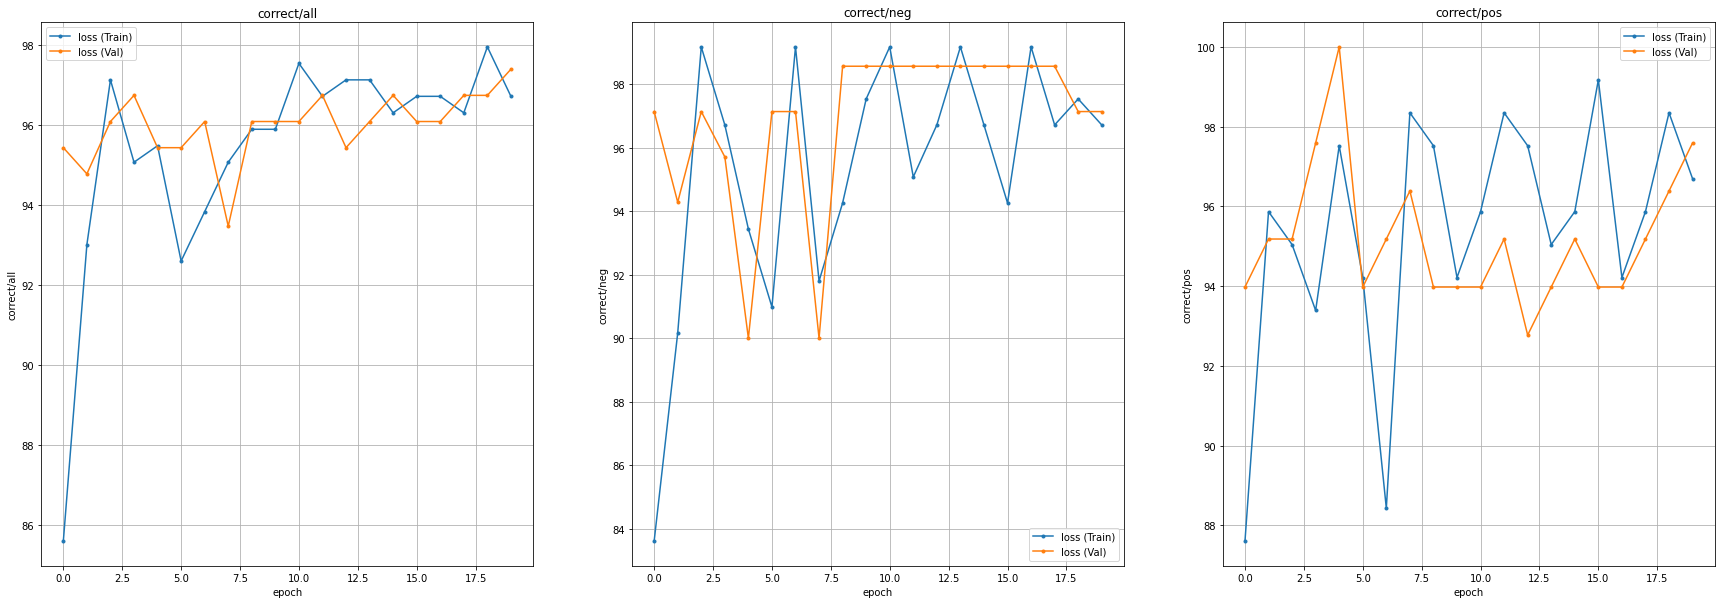

In [29]:
from socket import AF_AX25
import matplotlib.pyplot as plt
%matplotlib inline


fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(30,10))



# correct/all
ax1.plot(history_train['epoch_ndx'],history_train['correct/all'],
         marker='.',
         label='loss (Train)')
ax1.plot(history_val['epoch_ndx'],history_val['correct/all'],
         marker='.',
         label='loss (Val)')
ax1.legend(loc='best')
ax1.grid()
ax1.set_title('correct/all')
ax1.set_xlabel('epoch')
ax1.set_ylabel('correct/all')

# correct/all
ax2.plot(history_train['epoch_ndx'],history_train['correct/neg'],
         marker='.',
         label='loss (Train)')
ax2.plot(history_val['epoch_ndx'],history_val['correct/neg'],
         marker='.',
         label='loss (Val)')
ax2.legend(loc='best')
ax2.grid()
ax2.set_title('correct/neg')
ax2.set_xlabel('epoch')
ax2.set_ylabel('correct/neg')

# correct/all
ax3.plot(history_train['epoch_ndx'],history_train['correct/pos'],
         marker='.',
         label='loss (Train)')
ax3.plot(history_val['epoch_ndx'],history_val['correct/pos'],
         marker='.',
         label='loss (Val)')
ax3.legend(loc='best')
ax3.grid()
ax3.set_title('correct/pos')
ax3.set_xlabel('epoch')
ax3.set_ylabel('correct/pos')


plt.show()



#END